# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [13]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [14]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
cutoff = int(num_test/2)
test_data, test_labels = newsgroups_test.data[cutoff:], newsgroups_test.target[cutoff:]
dev_data, dev_labels = newsgroups_test.data[:cutoff], newsgroups_test.target[:cutoff]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [15]:
def P1(num_examples=5):
    [print('*******{1}*******\n{0}\n\n'.format(
        train_data[i].lstrip(),
        newsgroups_train.target_names[train_labels[i]])) 
     for i 
     in range(num_examples)]
    
P1()

*******comp.graphics*******
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


*******talk.religion.misc*******
Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [18]:
def P2():
    # perform a fit-transform on a vectorizer and display the results
    vectorizer = CountVectorizer()
    samples = vectorizer.fit_transform(train_data)
    sampleCount, vocabSize = samples.shape
    print('Vocabulary size: {0}'.format(vocabSize))
    print('Average non-zero features per example: {0}'.format( 
          int(samples.nnz / sampleCount)))
    print('Fraction of non-zero entries in matrix: {0}'.format( 
          samples.nnz / (sampleCount * vocabSize)))
    
    # display the first and last feature names
    featureNames = vectorizer.get_feature_names()
    print('First feature name is \'{0}\' and the last is \'{1}\''.format(
        featureNames[0], 
        featureNames[-1]))
    
    # fix a 4 word vocabulary on a vectorizer and display the average
    # nonzero features per example
    vectorizer = CountVectorizer(vocabulary=['atheism', 
                                             'graphics', 
                                             'space', 
                                             'religion'])
    samples = vectorizer.fit_transform(train_data)
    sampleCount, vocabSize = samples.shape
    print('Average non-zero features per example with vocab size {0} and sample count {1}: {2}'.format(
        vocabSize, 
        sampleCount,
        samples.nnz / sampleCount))
    
    # display the vocabulary size for a bigram vectorizer
    # and a trigram vectorizer
    vectorizer = CountVectorizer(ngram_range=(2,2))
    samples = vectorizer.fit_transform(train_data)
    sampleCount, vocabSize = samples.shape
    print('Vocab size for a bigram vectorizer:', vocabSize)
    
    vectorizer = CountVectorizer(ngram_range=(3,3))
    samples = vectorizer.fit_transform(train_data)
    sampleCount, vocabSize = samples.shape
    print('Vocab size for a trigram vectorizer:', vocabSize)
    
    # display the vocabulary size if the word must appear in a
    # minimum of 10 different documents
    vectorizer = CountVectorizer(max_df=10)
    samples = vectorizer.fit_transform(train_data)
    sampleCount, vocabSize = samples.shape
    print('Vocab size for vectorizer with 10 document minimum:', 
          vocabSize)
    
    # fit a vectorizer on both the training and dev data and
    # then compute the percentage of words in the development
    # vocabulary that do not appear in the training vocabulary
    trainVectorizer = CountVectorizer()
    trainVectorizer.fit_transform(train_data)
    trainVocabulary = list(trainVectorizer.vocabulary_.keys())
    devVectorizer = CountVectorizer()
    devVectorizer.fit_transform(dev_data)
    devVocabulary = list(devVectorizer.vocabulary_.keys())
    difference = np.setdiff1d(devVocabulary, 
                              trainVocabulary)
    print('Percentage of dev words missing from training: {0:.2f}%'.format( 
          100 * len(difference) / len(devVocabulary)))
P2()

Vocabulary size: 26879
Average non-zero features per example: 96
Fraction of non-zero entries in matrix: 0.0035978272269590263
First feature name is '00' and the last is 'zyxel'
Average non-zero features per example with vocab size 4 and sample count 2034: 0.26843657817109146
Vocab size for a bigram vectorizer: 194891
Vocab size for a trigram vectorizer: 315692
Vocab size for vectorizer with 10 document minimum: 24063
Percentage of dev words missing from training: 24.79%


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

KNN Classifier
Optimal value for n_neighbors: 48
F1 score at optimal value:  0.43433409932

Naive Bayes Classifier
Optimal value for alpha: 0.10204091428571428
F1 score at optimal value:  0.79030523851

Logistic Regression
Optimal value for C: 0.20408172857142856
F1 score at optimal value:  0.705873369398


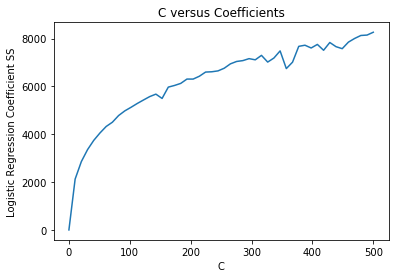

In [32]:
def ParameterSearch(
        classifier, 
        parameterName, 
        parameterRange):
    # create a pipeline with a vectorizer and the given classifier
    # and perform a grid search over the given parameter range
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', classifier),
    ])
    parameterKey = 'clf__{0}'.format(parameterName)
    parameters = {
        parameterKey : parameterRange,
    }
    search = GridSearchCV(
        pipeline, 
        parameters, 
        n_jobs = -1,
        scoring='f1_weighted')
    search.fit(
        train_data,
        train_labels)
    
    # display the optimal value of the given parameter and the
    # f1 score against the dev data. we choose a weighted score
    # here to reflect the potential of label imbalance.
    print('Optimal value for {0}: {1}'.format(
        parameterName, 
        search.best_estimator_.get_params()[parameterKey]))
    print("F1 score at optimal value: ", 
          metrics.f1_score(dev_labels, 
                           search.predict(dev_data), 
                           average='weighted'))

def P3():
    print('KNN Classifier')
    ParameterSearch(
        KNeighborsClassifier(), 
        'n_neighbors', 
        tuple(np.linspace(1,50,50,dtype=int)))
    
    print('\nNaive Bayes Classifier')
    ParameterSearch(
        MultinomialNB(), 
        'alpha', 
        tuple(np.linspace(.0000001,5,50)))

    print('\nLogistic Regression')
    ParameterSearch(
        LogisticRegression(), 
        'C', 
        tuple(np.linspace(.0000001,5,50)))
    
    # create an array of the sum of the squares of the 
    # regression coefficients and the corresponding 
    # regularization parameter C
    samples = CountVectorizer().fit_transform(train_data)
    cs = np.linspace(.0000001,500,50)
    coefs = []
    for c in cs:
        reg = LogisticRegression(C=c)
        reg.fit(
            samples,
            train_labels)
        coefs.append(sum(sum(reg.coef_**2)))
    
    plt.plot(cs, coefs)
    plt.title('C versus Coefficients')
    plt.xlabel("C")
    plt.ylabel("Logistic Regression Coefficient SS")
P3()

ANSWER:
(a) KNN in general struggles with high dimensional parameter spaces (curse of dimensionality problem). In this case we have 26,879 parameter samples, many of which may not be relevant. For example short words such as prepositions may appear so often that they do not give you any information about the label. Removing those words could help. Another technique to reduce the parameter space is to remove the suffix from words.

(b) We are given a small training sample size (676) relative to the parameter space (26879). Since Logistic Regression works by estimating $p(category|text)$ directly it may overfit the data given this smaller sample size and large parameter space. On the other hand since Naive Bayes estimates a probability from a joint distribution $p(category, text)=p(text)p(text|category)$ it may be less prone to overfit in this scenario.

(c) The relationship between C and the sum of squares on the coefficients appears to have a logarithmic shape. You would expect that the relationship would be positive since C is the inverse of the regularization strength. Thus as C gets larger, less regularization is taking place and the values of the coefficients can be higher. It would make sense that the function is asymptotic: at some point you will approach unregularized regression.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [20]:
def CreateFeatureWeightTable(ngram=(1,1)):
    # create a pipeline with an ngram vectorizer and a logistic regression
    # classifier and fit the data
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=ngram)),
        ('clf', LogisticRegression(C=.2)),
    ])
    pipeline.fit(
        train_data, 
        train_labels)
    vectorizer, classifier = pipeline.named_steps['vect'], pipeline.named_steps['clf']
    
    # find the indicies of the maximum coefficients for each training label
    # and flatten that array
    maxWeightIndicies = np.array([np.argpartition(row, -5)[-5:] 
                                  for row
                                  in classifier.coef_]).flatten()

    
    # get the parameter names and values for each one of the indicies
    parameterNames = np.array(vectorizer.get_feature_names())[maxWeightIndicies]
    parameterValues = np.transpose(classifier.coef_[:, maxWeightIndicies])

    # print the header row with label names
    print('{:<20} {:<15} {:<15} {:<15} {:<15}'.format(
            'Feature', 
            newsgroups_train.target_names[0], 
            newsgroups_train.target_names[1], 
            newsgroups_train.target_names[2], 
            newsgroups_train.target_names[3]))

    # print each weight row by parameter name
    for i in range(len(parameterNames)):
        print('{:<20} {:<15,.2f} {:<15,.2f} {:<15,.2f} {:<15,.2f}'.format(
                parameterNames[i], 
                parameterValues[i][0], 
                parameterValues[i][1], 
                parameterValues[i][2], 
                parameterValues[i][3]))

def P4():
    print('Unigram Feature Weight Table')
    CreateFeatureWeightTable()
    
    print('\nBigram Feature Weight Table')
    CreateFeatureWeightTable((2,2))
P4()

Unigram Feature Weight Table
Feature              alt.atheism     comp.graphics   sci.space       talk.religion.misc
islam                0.53            -0.09           -0.21           -0.21          
atheists             0.61            -0.09           -0.20           -0.42          
religion             0.62            -0.38           -0.50           -0.02          
atheism              0.62            -0.27           -0.27           -0.31          
bobby                0.62            -0.15           -0.22           -0.29          
computer             -0.00           0.68            -0.43           -0.29          
3d                   -0.23           0.71            -0.41           -0.24          
graphics             -0.50           1.26            -0.83           -0.47          
image                -0.34           0.83            -0.49           -0.28          
file                 -0.21           0.81            -0.53           -0.37          
spacecraft           -0.22       

ANSWER: In the unigram table the positively weighted features seem to make intuitive sense given the label (islam, athiest are alt.atheism, computer, 3d are comp.graphics). However in the bigram table there are a lot of seemingly unrelated noun and prepositional phrases. In addition the bigram parameter 'cheers kent' appears in both the talk.religion.misc and the alt.atheism label which, again, seems to have no relationship to the labels.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [46]:
numberRegex = re.compile(r'(\b\d+\b)', re.IGNORECASE)
specialCharacterRegex = re.compile('([^a-zA-Z0-9])', re.IGNORECASE)
longWordsRegex = re.compile(r'(\b\w{20,}\b)', re.IGNORECASE)
shortWordsRegex = re.compile(r'(\b\w{1,4}\b)', re.IGNORECASE)

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    # remove short and long words, condense all numbers down into
    # a single number, and remove special characters
    result = s.lower().replace('\'', '');
    result = specialCharacterRegex.sub(' ', result)
    result = longWordsRegex.sub('LONGWORD', result)
    result = shortWordsRegex.sub('SHORTWORD', result)
    result = numberRegex.sub('NUMBER', result)
    return result

def GetLogisticRegressionF1Score(preprocessor):
    # create a pipeline with a vectorizer and a logistic
    # regression and perform a fit
    pipeline = Pipeline([
        ('vect', CountVectorizer(preprocessor=preprocessor)),
        ('clf', LogisticRegression()),
    ])
    pipeline.fit(
        train_data, 
        train_labels)    
    
    # calculate the f1 score from predictions on dev_data
    # we again choose weighted f1 to protect against label
    # imbalance
    print('Weighted F1 score: {:.3f}'.format(
          metrics.f1_score(dev_labels, 
                           pipeline.predict(dev_data), 
                           average='weighted')))
    
    # get the dictionary size from the vectorizer
    dictionarySize = len(pipeline.named_steps['vect'].vocabulary_)
    print('Dictionary size: {0}'.format(dictionarySize))

    #np.savetxt('vocab.out', list(pipeline.named_steps['vect'].vocabulary_.keys()), delimiter=',', fmt='%s')
    return dictionarySize
          
def P5():
    print('Empty preprocessor')
    emptyPreprocessorDictionarySize = GetLogisticRegressionF1Score(empty_preprocessor)
    
    print('\nBetter preprocessor')
    betterPreprocessorDictionarySize = GetLogisticRegressionF1Score(better_preprocessor)
    
    print('\nDictionary size reduction: {0} words'.format(
        emptyPreprocessorDictionarySize - betterPreprocessorDictionarySize))
P5()

Empty preprocessor
Weighted F1 score: 0.702
Dictionary size: 33291

Better preprocessor
Weighted F1 score: 0.723
Dictionary size: 20689

Dictionary size reduction: 12602 words


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

L1 vs L2 Comparison
Non-zero weights with l1: 1080
Weighted F1 score for l1 penalty: 0.691
Non-zero weights with l2: 26879
Weighted F1 score for l2 penalty: 0.704


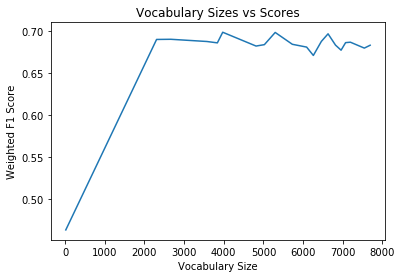

In [28]:
def RunLogisticRegresionPrintResults(
        penalty='l2', 
        C=1.0, 
        vocabulary=None):
    score, vocabulary = RunLogisticRegression(penalty, 
                                              C, 
                                              vocabulary)
    
    print('Non-zero weights with {0}: {1}'.format(penalty, 
                                                  len(vocabulary)))
    print("Weighted F1 score for {0} penalty: {1:.3f}".format(penalty,
                                                     score))
    
def RunLogisticRegression(
        penalty='l2',
        C=1.0, 
        vocabulary=None):
    # create a train a pipeline with a vectorizer and logistic regression
    # with the given parameters
    pipeline = Pipeline([
        ('vect', CountVectorizer(vocabulary=vocabulary)),
        ('clf', LogisticRegression(C=C, 
                                   penalty=penalty, 
                                   tol=.01)),
    ])
    vectorizer, classifier = pipeline.named_steps['vect'], pipeline.named_steps['clf']
    pipeline.fit(
        train_data, 
        train_labels)

    # get the vocabulary by indexing feature names by the non-zero elements
    # across all of the labels
    vocabulary = np.array(vectorizer.get_feature_names())[np.nonzero(np.sum(classifier.coef_, 
                                                                            axis=0))]
    score = metrics.f1_score(dev_labels, 
                             pipeline.predict(dev_data), 
                             average='weighted')
    return score, vocabulary
          
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    print('L1 vs L2 Comparison')
    RunLogisticRegresionPrintResults(penalty='l1')
    RunLogisticRegresionPrintResults()
    
    sizes = []
    scores = []
    for c in np.linspace(.01,100,20):
        _, prunedVocabulary = RunLogisticRegression(C=c, 
                                                    penalty='l1')
        score, _ = RunLogisticRegression(C=c,
                                         vocabulary=prunedVocabulary)
        scores.append(score)
        sizes.append(len(prunedVocabulary))
    
    plt.plot(sizes, scores)
    plt.title('Vocabulary Sizes vs Scores')
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Weighted F1 Score")
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [47]:
def P7():
    # create a train a pipeline with a vectorizer and logistic regression
    # with the given parameters
    pipeline = Pipeline([
        ('vect', TfidfVectorizer()),
        ('clf', LogisticRegression(C=100)),
    ])
    vectorizer, classifier = pipeline.named_steps['vect'], pipeline.named_steps['clf']
    pipeline.fit(
        train_data, 
        train_labels)
    score = metrics.f1_score(dev_labels, 
                         pipeline.predict(dev_data), 
                         average='weighted')
    print('Weighted F1 score for c=100 with Tfidf vectorizer: {0}\n'.format(score))
    
    # get the dev data label probabilities from the trained classifier
    labelProbabilities = classifier.predict_proba(vectorizer.transform(dev_data))
    
    # find the maximum predicted probability for each sample
    maximumProbability = np.amax(labelProbabilities, 
                                          axis=1)
    
    # find the predicted probability of the correct label
    probabilityOfCorrectLabel = labelProbabilities[np.array(range(len(dev_labels))), 
                                                   dev_labels]
    
    # get the indicies of the largest confidence errors
    maxIndicies = np.argpartition(maximumProbability / probabilityOfCorrectLabel, -3)[-3:]
    
    # print out the text for the 3 most mistaken dev examples
    for doc in maxIndicies:
        print('---Was **{0}** but thought was **{1}**---'.format(newsgroups_train.target_names[dev_labels[doc]], 
                                                         newsgroups_train.target_names[np.argmax(labelProbabilities[doc])]))
        print(dev_data[doc], '\n')


P7() 

Weighted F1 score for c=100 with Tfidf vectorizer: 0.7597662427853104

---Was **alt.atheism** but thought was **talk.religion.misc**---

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
 

---Was **talk.religion.misc** but thought was **comp.graphics**---
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 

---Was **talk.religion.misc** but thought was **comp.graphics**---
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith St

ANSWER: The count vectorizer simply computes the sum of all the words in a document. The Tfidf vectorizer essentially computes how 'important' a particular word is to a specific document. It is the product of the term frequency in the document with the information provided across all documents.

The first mistaken example is very short and is an atheism/religion mismatch which seems highly likely. The other two are both religion/computer mismatches and occur because there is a large ratio of tech speak (ftp, email) to other words and that seems to outweigh the sole religious term 'Morman'.

One way to fix this would be to create a customized list of stop words. Since we are dealing with newsgroup text one could assume that the usage of tech words like email and ftp are just a quality of the environment of the text. Similarly you could set an upper limit on the document frequency, max_df, for the vectorizer which should eliminate these more prevalant words.

Another solution might be to add in n-gram features to try and capture the 'sentiment' of some of the words in the document. In the last example he or she seems to be speaking highly of the Book of Morman which is a concept you might find would be associated with talk.religion.misc rather than comp.graphics.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.